# 使用 GCN 和 LSTM 对 API Call Sequence 进行 malware 检测

In [99]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

SEED = 137
np.random.seed(SEED)

import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import precision_score, f1_score, roc_auc_score, roc_curve
from sklearn import decomposition
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch.classifier import NeuralNetBinaryClassifier
from sklearn.pipeline import Pipeline

In [82]:
path = '/Volumes/Library/SynologyDrive/data/AI_Cheats/'
# 数据加载
df = pd.read_csv(path + 'dynamic_api_call_sequence_per_malware_100_0_306.csv')
df.head()

,hash,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,071e8c3f8922e186e57548cd4c703a5d,112,274,158,215,274,158,215,298,76,...,71,297,135,171,215,35,208,56,71,1
1,33f8e6d08a6aae939f25a8e0d63dd523,82,208,187,208,172,117,172,117,172,...,81,240,117,71,297,135,171,215,35,1
2,b68abd064e975e1c6d5f25e748663076,16,110,240,117,240,117,240,117,240,...,65,112,123,65,112,123,65,113,112,1
3,72049be7bd30ea61297ea624ae198067,82,208,187,208,172,117,172,117,172,...,208,302,208,302,187,208,302,228,302,1
4,c9b3700a77facf29172f32df6bc77f48,82,240,117,240,117,240,117,240,117,...,209,260,40,209,260,141,260,141,260,1


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43876 entries, 0 to 43875
Columns: 102 entries, hash to malware
dtypes: int64(101), object(1)
memory usage: 34.1+ MB


In [84]:
# 得到特征 X 和目标 Y
X = df.drop(['hash', 'malware'], axis=1).values.astype(int)
y = df['malware'].values.astype(int)
print(X.shape)
print(y.shape)

(43876, 100)
(43876,)


In [85]:
# 数据探索，说明 X 特征矩阵取值为 0-306
print(X.min())
print(X.max())

0
306


In [86]:
# 检查样本是否均匀
def check_imbalance(dataset):
  count = sorted(Counter(dataset).items())
  print(count)
  print(count[1][1]/count[0][1])
  return
check_imbalance(y)

[(0, 1079), (1, 42797)]
39.66357738646895


In [87]:
# 训练集 70%, 测试集 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

In [88]:
check_imbalance(y_train)
check_imbalance(y_test)

# 释放不用的变量
del df, X, y

[(0, 731), (1, 29982)]
41.015047879616965
[(0, 348), (1, 12815)]
36.82471264367816


### 定义 GCN 模型

In [90]:
# 计算邻接矩阵 A 和 D 矩阵
def norn_adj(X, input_dim_1):
  # batch_size, input_dim_1, input_dim_1
  temp = X.cpu().numpy()
  A_adj = np.zeros([X.size(0), input_dim_1, input_dim_1])

  for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
      x1 = int(temp[i,j])
      if j!=(temp.shape[1] - 1):
        x2 = int(temp[i, j+1])
        A_adj[i][x1][x2] = 1.0
        # print(A_adj[i][x1][x2])
  # 计算邻接矩阵      
  A = torch.from_numpy(A_adj).float()

  # A_hat 为 A 的单位矩阵之和
  A_hat = A + torch.eye(input_dim_1, dtype = torch.float)
  D_hat = A_hat.sum(dim = 1).pow(-1.0).diag_embed()

  return A_hat, D_hat

In [91]:
# 对 X 进行 one-hot 特征提取
def to_one_hot(X, input_dim_1):
  X = F.one_hot(X, num_classes = input_dim_1).float()
  # 正常顺序(0, 1, 2) => (0, 2, 1)
  X = X.permute(0, 2, 1)
  return X

In [108]:
class GCN_network(nn.Module):
  def __init__(self, weight_dim_1, weight_dim_2):
    super(GCN_network, self).__init__()
    self.weight_dim_1 = weight_dim_1
    self.weight_dim_2 = weight_dim_2
    # 权重随机生成，y = wx+b 里那个 w
    self.weights = nn.Parameter(torch.rand((self.weight_dim_1, weight_dim_2), dtype = torch.float, requires_grad = True))

  def forward(self, A_hat, D_hat, X):
    return D_hat.matmul(A_hat).matmul(X).matmul(self.weights)

### 定义 GCN网络(model_1)

In [109]:
# 使用 1 层 GCN 层
H_list_model_1 = []
class Model_1_network(nn.Module):
  def __init__(self, input_dim_1, input_dim_2, weight_dim_2, dropout_rate):
    super(Model_1_network, self).__init__()
    self.input_dim_1 = input_dim_1
    self.input_dim_2 = input_dim_2
    self.weight_dim_1 = input_dim_2
    self.weight_dim_2 = weight_dim_2
    self.dropout_rate = dropout_rate

    # 定义 GCN 层，AX 其实理解成 X 中每个节点对周围的加权，然后再过线性变换
    self.gcn = GCN_network(self.weight_dim_1, self.weight_dim_2)
    # 定义 dropout
    self.dropout = nn.Dropout(p = self.dropout_rate)
    # 定义 FC 层
    self.fc = nn.Linear(self.input_dim_1 * self.weight_dim_2, 1)

  # 前向传播
  def forward(self, X):
    # 通过 X 得到 A_hat, D_hat
    A_hat, D_hat = norn_adj(X, self.input_dim_1)
    X = to_one_hot(X, self.input_dim_1)

    # 将 A_hat, D_hat, X 作为输入，传入 GCN 层
    H = self.gcn(A_hat, D_hat, X)
    H = self.dropout(H)
    H = torch.relu(H)

    # 变成两维，第一个维度保持不变，后面的很多维全部变成一维
    H = H.view(H.size(0), -1)

    # 预测阶段，进行可视化时
    if not self.training:
      H_list_model_1.append(H.cpu())
    H = self.fc(H)
    return H.squeeze()
  

### 定义 LSTM模型

In [94]:
H_list_lstm = []
# 定义LSTM
class LSTM_network(nn.Module):
  def __init__(self, input_dim, hidden_dim, dropout_rate):
    super(LSTM_network, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.dropout_rate = dropout_rate
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, batch_first=True)
    self.dropout = nn.Dropout(p = self.dropout_rate)
    self.fc = nn.Linear(self.hidden_dim, 1)
  # 前向传播
  def forward(self, X):
    # 对X进行one_hot特征提取
    X = F.one_hot(X, num_classes = self.input_dim).float()
    # 隐藏层形状：(num_layers, batch_size, hidden_dim)
    hidden_0 = (torch.zeros(1, X.size(0), self.hidden_dim).float(), torch.zeros(1, X.size(0), self.hidden_dim).float())
    # 输入/输出形状: (batch_size, seq_len, hidden_0)
    _, self.hidden = self.lstm(X, hidden_0)
    H = self.hidden[0].squeeze()
    H = self.dropout(H)

    # 可视化时用到
    H_list_lstm.append(H.cpu())
    H = self.fc(H)
    return H.squeeze()

### 模型评估

In [95]:
# 模型评估
def model_evaluate(y, pred):
  print('Confusion matrix\n[TN FP]\n[FN TP]')
  # confusion_matrix(y_true, y_pred)
  print(confusion_matrix(y >= 0.5, pred >= 0.5))
  print(f'F1-Score: {f1_score(y >= 0.5, pred >= 0.5): .4f}')
  print(f'ROC-AUC: {roc_auc_score(y, pred): .4f}')

### LSTM 网络

In [96]:
torch.manual_seed(SEED)
# LSTM 超参数设置
input_dim = 307
hidden_dim = 70
dropout_rate = 0.5
batch_size = 128
max_epochs = 2

In [97]:
# 使用LSTM做二分类
LSTM = NeuralNetBinaryClassifier(
  LSTM_network,
  module__input_dim = input_dim,
  module__hidden_dim = hidden_dim,
  module__dropout_rate = dropout_rate,
  batch_size = batch_size,
  max_epochs = max_epochs,
  train_split = None,
  optimizer = torch.optim.Adam,
  iterator_train__shuffle = True,
  device = 'cpu'
)

# 定义 pipeline
pipe = Pipeline([
  ('model', LSTM)
])

# 使用LSTM进行训练
pipe.fit(X_train, y_train.astype(float))

  epoch    train_loss      dur
-------  ------------  -------
      1        0.1188  13.4787
      2        0.0835  13.1750


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=LSTM_network(
    (lstm): LSTM(307, 70, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (fc): Linear(in_features=70, out_features=1, bias=True)
  ),
))])

In [100]:
H_list_lstm.clear()
# 得到预测结果
X_test_predictions_1 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, np.ones(len(y_test)))
print(X_test_predictions_1)
print(y_test)

# 对LSTM预测结果进行评估
model_evaluate(y_test, X_test_predictions_1)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score:  0.9866
ROC-AUC:  0.5000
[0.99655116 0.99344033 0.86208236 ... 0.99403644 0.97203976 0.9942034 ]
[1 1 1 ... 1 1 1]
Confusion matrix
[TN FP]
[FN TP]
[[   94   254]
 [    1 12814]]
F1-Score:  0.9901
ROC-AUC:  0.8677


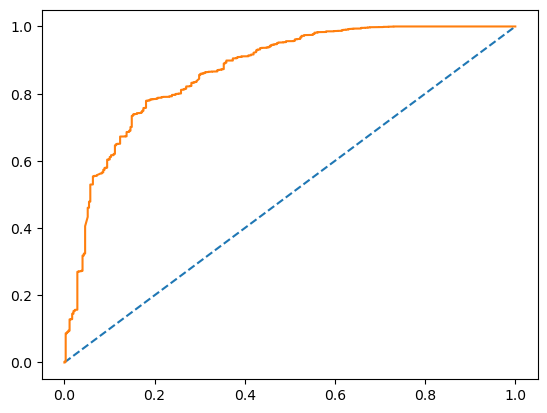

In [101]:
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, X_test_predictions_1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_1, tpr_1)
plt.show()

In [102]:
# 可视化
def visualize(X, y, points, n_features):
  # points 随机排列
  points = np.arange(points)
  np.random.shuffle(points)
  color = ['red' if l == 1 else 'green' for l in y[points]]
  for i in range(n_features):
    for j in range(n_features):
      if j > i:
        plt.scatter(X[points, i], X[points, j], color = color)
        plt.pause(0.1)
  return

In [103]:
# 使用 PCA 压缩到 2 维，进行可视化
def visualize_pca(X, y):
  # 归一化
  X = X / np.max(X)
  # 使用 PCA 进行压缩
  pca = decomposition.PCA(n_components = 2)
  # 可视化
  visualize(pca.fit_transform(X), y, X.shape[0], 2)
  return

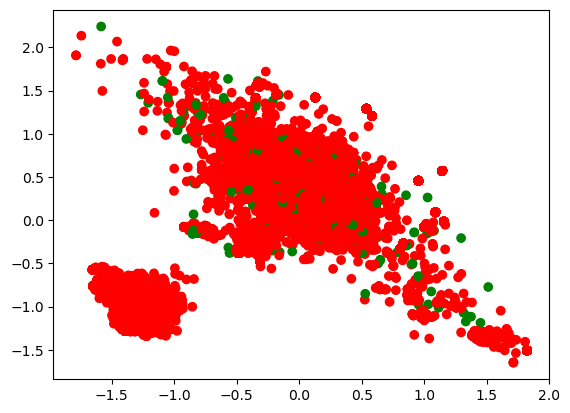

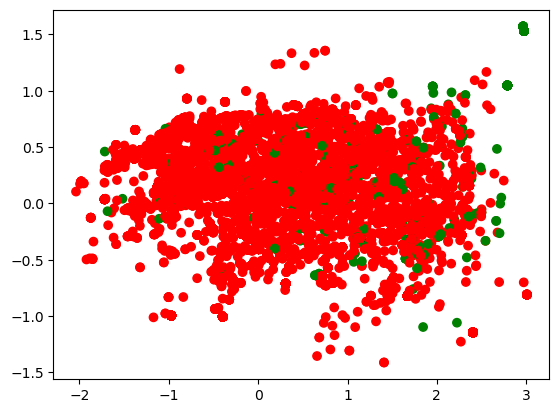

In [104]:
visualize_pca(X_test, y_test)
result = torch.zeros(1, 70)
for i in H_list_lstm:
  result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]
visualize_pca(X_result, y_test)

### 使用 GCN 网络进行学习

In [110]:
torch.manual_seed(SEED)
# 输入 dim=307
input_dim_1 = 307
# GCN dim = 100
input_dim_2 = 100
weight_dim_2 = 31
dropout_rate = 0.6
batch_size = 128
max_epochs = 2
# 使用 GCN 做二分类
model_1 = NeuralNetBinaryClassifier(
  Model_1_network,
  module__input_dim_1 = input_dim_1,
  module__input_dim_2 = input_dim_2,
  module__weight_dim_2 = weight_dim_2,
  module__dropout_rate = dropout_rate,
  batch_size = batch_size,
  max_epochs = max_epochs,
  train_split = None,
  optimizer = torch.optim.Adam,
  iterator_train__shuffle = True,
  device = 'cpu'
)

pipe = Pipeline([
  ('model', model_1)
])

pipe.fit(X_train, y_train.astype(float))

  epoch    train_loss      dur
-------  ------------  -------
      1        0.1645  15.3332
      2        0.0450  15.3720


Pipeline(steps=[('model',
                 <class 'skorch.classifier.NeuralNetBinaryClassifier'>[initialized](
  module_=Model_1_network(
    (gcn): GCN_network()
    (dropout): Dropout(p=0.6, inplace=False)
    (fc): Linear(in_features=9517, out_features=1, bias=True)
  ),
))])

In [111]:
H_list_model_1.clear()

X_test_predictions_2 = pipe.predict_proba(X_test)[:, 1]
model_evaluate(y_test, np.ones(len(y_test)))
model_evaluate(y_test, X_test_predictions_2)

Confusion matrix
[TN FP]
[FN TP]
[[    0   348]
 [    0 12815]]
F1-Score:  0.9866
ROC-AUC:  0.5000
Confusion matrix
[TN FP]
[FN TP]
[[  201   147]
 [   23 12792]]
F1-Score:  0.9934
ROC-AUC:  0.9726


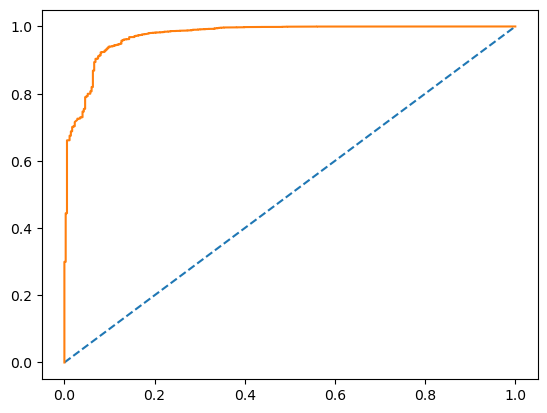

In [112]:
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, X_test_predictions_2)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr_2, tpr_2)
plt.show()

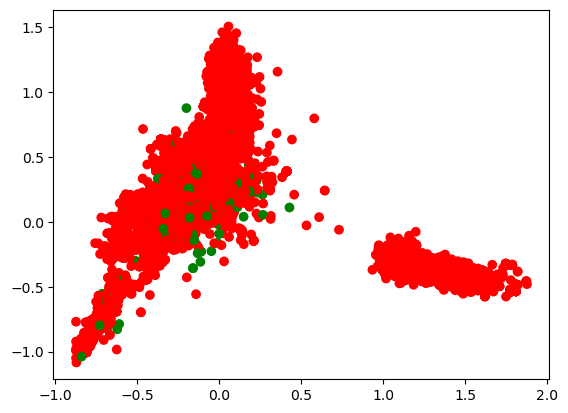

In [113]:
result = torch.zeros(1, 9517)
for i in H_list_model_1:
  result = torch.cat([result, i.cpu()], 0)

X_result = result.numpy()[1:]
visualize_pca(X_result, y_test)